In [1]:
import os
import sys
import json
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Tuple, Dict, Any, Optional



In [2]:
PATH_GROQ_TOKEN = "../groq_token.txt"
GROQ_TOKEN = Path(PATH_GROQ_TOKEN).read_text().strip()
import groq

# Export the GROQ_TOKEN as GROQ_API_KEY
os.environ['GROQ_API_KEY'] = GROQ_TOKEN


In [3]:
# Test run
# DIR_PROGRAM_BANK = os.path.join("..", "program_bank", "v001", "2024_10_04__14_48__qiskit")

# Run with 10k programs: v001.yaml
# program_bank/v001/2024_10_04__15_10__qiskit
DIR_PROGRAM_BANK = os.path.join("..", "program_bank", "v001", "2024_10_04__15_10__qiskit")
# program_bank/v002/2024_10_07__17_03__qiskit
# DIR_PROGRAM_BANK = os.path.join("..", "program_bank", "v002", "2024_10_07__17_03__qiskit")

In [4]:
from multiprocessing import Pool
import re

def read_json_file(file_path: str) -> Dict[str, Any]:
    with open(file_path, 'r') as file:
        data = json.load(file)
        data["error_file"] = os.path.basename(file_path)
        return data

def read_all_programs(dir_path: str) -> pd.DataFrame:
    json_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if re.match(r'.*_error\.json$', f)]
    records = []

    with Pool() as pool:
        results = pool.map(read_json_file, json_files)
        records.extend(results)

    return pd.DataFrame(records)

# Use the function to read all programs
df_errors = read_all_programs(DIR_PROGRAM_BANK)

# augment the dataframe with the proram content
def read_file_content(file_name: str) -> str:
    file_path = os.path.join(DIR_PROGRAM_BANK, file_name)
    with open(file_path, 'r') as file:
        return file.read()

# Use parallel apply to read the file content
with Pool() as pool:
    df_errors['file_content'] = pool.map(read_file_content, df_errors['current_file'])

# Alternatively, you can use apply without parallel processing
# df_errors['file_content'] = df_errors['current_file'].apply(read_file_content)

df_errors.head()


,exception_message,stack_trace,current_file,involved_functions,error_file,file_content
0,"""<input>:7,35: 'u' is not defined in this scope""","Traceback (most recent call last):\n File ""/w...",qiskit_circuit_30q_10g_1234_fdcc29.py,"[import_from_qasm_with_qiskit, export_to_qasm_...",qiskit_circuit_30q_10g_1234_fdcc29_ab3f30_erro...,# Section: Prologue\nfrom qiskit import Quantu...
1,"""<input>:8,0: 'cp' is not defined in this scope""","Traceback (most recent call last):\n File ""/w...",qiskit_circuit_30q_10g_8744_10c238.py,"[import_from_qasm_with_qiskit, export_to_qasm_...",qiskit_circuit_30q_10g_8744_10c238_9cc395_erro...,# Section: Prologue\nfrom qiskit import Quantu...
2,The circuits are not equivalent: /workspace/qi...,"Traceback (most recent call last):\n File ""/w...",qiskit_circuit_30q_10g_6256_36e318.py,"[compare_qasm_via_qcec, export_to_qasm_with_pe...",qiskit_circuit_30q_10g_6256_36e318_441fe8_erro...,# Section: Prologue\nfrom qiskit import Quantu...
3,Operation MidMeasureMP not supported by the QA...,"Traceback (most recent call last):\n File ""/u...",qiskit_circuit_30q_10g_1569_44bb11.py,[export_to_qasm_with_pennylane],qiskit_circuit_30q_10g_1569_44bb11_d5b2a7_erro...,# Section: Prologue\nfrom qiskit import Quantu...
4,Could not import second circuit: <input>:3:6:\...,"Traceback (most recent call last):\n File ""/w...",qiskit_circuit_30q_10g_603_fbaea1.py,"[compare_qasm_via_qcec, export_to_qasm_with_pe...",qiskit_circuit_30q_10g_603_fbaea1_c57d9d_error...,# Section: Prologue\nfrom qiskit import Quantu...


In [5]:
# Print the first line of the 'file_content' column for the first row
first_line = df_errors['file_content'].iloc[0]
print(first_line)

# Extract the essential file content between "# <START_GATES>" and "# <END_GATES>"
def extract_essential_content(file_content: str) -> str:
    start_marker = "# <START_GATES>"
    end_marker = "# <END_GATES>"
    start_index = file_content.find(start_marker)
    end_index = file_content.find(end_marker, start_index)
    if start_index != -1 and end_index != -1:
        return file_content[start_index + len(start_marker):end_index].strip()
    return ""

df_errors['essential_file_content'] = df_errors['file_content'].apply(extract_essential_content)

# Print the first extracted essential file content
print(df_errors['essential_file_content'].iloc[0])


# Section: Prologue
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Session, Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Section: Circuit
qr = QuantumRegister(30, name='qr')
cr = ClassicalRegister(30, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')

# Apply gate operations
# <START_GATES>
qc.crx(5.398049, qr[27], qr[13])
qc.measure(qr[23], cr[26])
qc.delay(5, qr[9], unit='dt')
qc.delay(3, qr[0], unit='dt')
qc.h(qr[4])
qc.ecr(qr[29], qr[15])
qc.measure(qr[25], cr[0])
qc.cp(2.001557, qr[12], qr[18])
qc.mcp(0.120775, [qr[0], qr[16], qr[24]], qr[19])
qc.s(qr[15])
# <END_GATES>

# Section: Measurement
qc.measure(qr, cr)




# Helper Functions
import os
import traceback
import json
import uuid
import sys
import inspect
from pathlib import Path
from typing import List, Dict, Any, Callable, Tuple, Optional


def get_functions(prefix: str) -> List[Callable]:
 

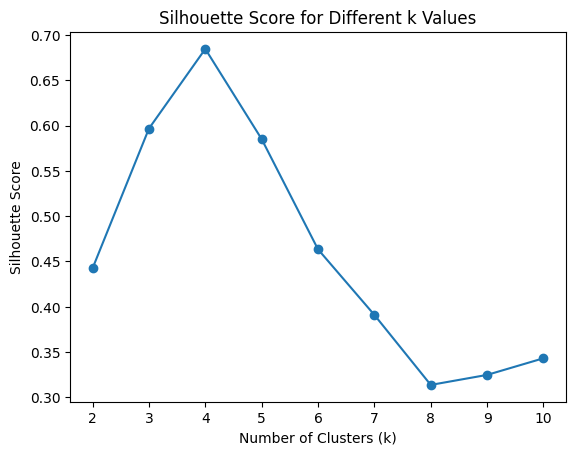

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs

# Generate synthetic dataset
X, _ = make_blobs(n_samples=500, centers=4, cluster_std=0.60, random_state=0)

# List to store silhouette scores
silhouette_scores = []

# Range of k values to test
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Plotting the results
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k Values')
plt.show()

0     "<input>:7,35: 'u' is not defined in this scope"
1     "<input>:8,0: 'cp' is not defined in this scope"
2    The circuits are not equivalent: /workspace/qi...
3    Operation MidMeasureMP not supported by the QA...
4    Could not import second circuit: <input>:3:6:\...
dtype: object
(35523, 10)
Running K-Means with K=2
Running K-Means with K=3
Running K-Means with K=4
Running K-Means with K=5
Running K-Means with K=6
Running K-Means with K=7
Running K-Means with K=8
Running K-Means with K=9
Running K-Means with K=10


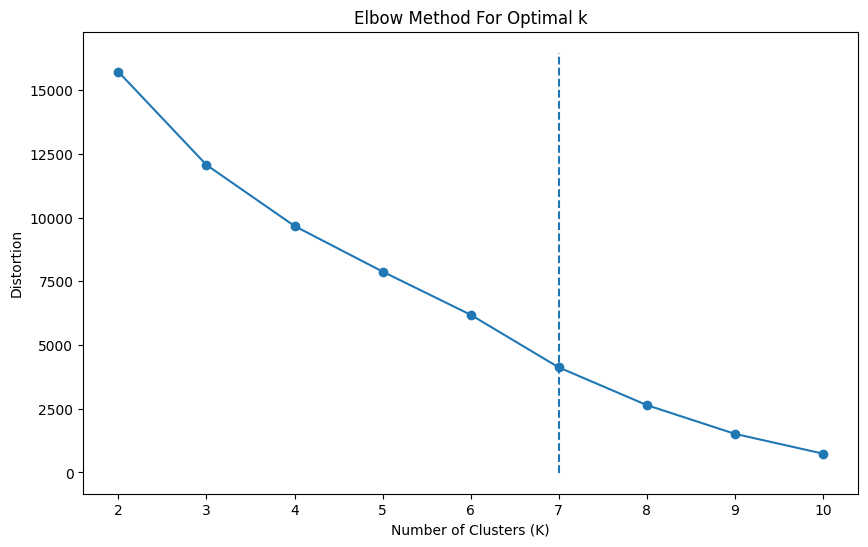

Optimal K (knead): 7


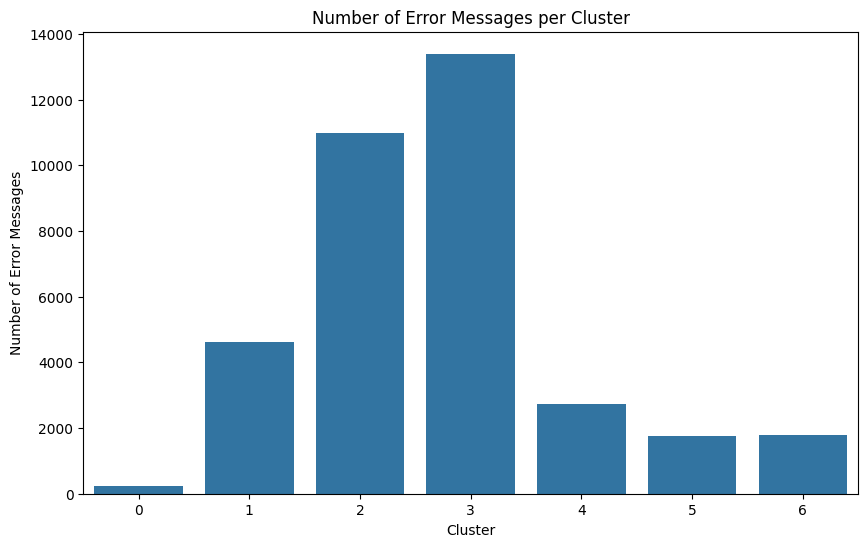

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
import random
from typing import List, Dict
from scipy.sparse import csr_matrix, vstack
from sklearn.decomposition import PCA


def run_analysis(df: pd.DataFrame, n_clusters: int, input_columns: List[str] = ['exception_message']) -> pd.DataFrame:
    # Combine the specified columns into a single text column
    combined_text = df[input_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

    # Vectorize the text data
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(combined_text)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_

    # Add the cluster labels to the dataframe
    df['cluster'] = labels
    return df

def plot_clusters(df: pd.DataFrame):
    # Visualize the results using a bar plot
    plt.figure(figsize=(10, 6))
    sns.countplot(x='cluster', data=df)
    plt.title('Number of Error Messages per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Error Messages')
    plt.show()

def stratified_sampling(data, labels, sample_size=100) -> Tuple[np.ndarray, np.ndarray]:
    """Sample data points from each cluster.

    Arguments:
    - data: the data points as csr matrix
    - labels: the cluster labels of the data points [list of int]
    - sample_size: the number of samples to take from each cluster

    Implementation:
    first extract all the X representing data from the same cluster
    (using label information)
    then sample the data points from the cluster
    """
    map_label_to_data = {}
    for label in np.unique(labels):
        # Extract all data points from the same cluster
        X_cluster = data[labels == label]
        # Sample the data points
        if X_cluster.shape[0] > sample_size:
            X_sampled = X_cluster[np.random.choice(X_cluster.shape[0], sample_size, replace=False)]
        else:
            X_sampled = X_cluster
        # Store the sampled data points
        map_label_to_data[label] = X_sampled
    # concatenate the sampled data points
    for k, v in map_label_to_data.items():
        print(f'Cluster {k}: {v.shape[0]} data points')

    # concatenate data points from all clusters
    if isinstance(data, csr_matrix):
        X_sampled = vstack([X_cluster for X_cluster in map_label_to_data.values()])
    else:
        X_sampled = np.vstack([X_cluster.toarray() if isinstance(X_cluster, csr_matrix) else X_cluster for X_cluster in map_label_to_data.values()])
    # create the corresponding labels
    sampled_labels = []
    for label, X_cluster in map_label_to_data.items():
        sampled_labels.extend([label] * X_cluster.shape[0])
    nd_sampled_labels = np.array(sampled_labels)
    assert X_sampled.shape[0] == nd_sampled_labels.shape[0], 'The number of data points and labels should match'
    return X_sampled, nd_sampled_labels

# Test cases
def test_stratified_sampling():

    # Create a small dataset
    data = csr_matrix([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 1, 0],
        [0, 1, 1],
        [1, 0, 1]
    ])
    labels = np.array([0, 0, 1, 1, 2, 2])

    # Test with sample size less than the number of data points in each cluster
    X_sampled, sampled_labels = stratified_sampling(data, labels, sample_size=1)
    assert X_sampled.shape[0] == 3, "Test case 1 failed"
    assert len(np.unique(sampled_labels)) == 3, "Test case 1 failed"

    # Test with sample size more than the number of data points in each cluster
    X_sampled, sampled_labels = stratified_sampling(data, labels, sample_size=3)
    assert X_sampled.shape[0] == 6, "Test case 2 failed"
    assert len(np.unique(sampled_labels)) == 3, "Test case 2 failed"

    print("All test cases passed!")

# Run test cases
# test_stratified_sampling()

def find_optimal_k_silhouette(data, k_range: range = range(2, 11)) -> int:
    silhouette_scores = []
    random.seed(42)
    for k in k_range:
        print(f'Running K-Means with K={k}')
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)

        # Sample data points from each cluster
        X_sampled, sampled_labels = stratified_sampling(data, kmeans.labels_)

        # Compute silhouette score on the sampled data
        score = silhouette_score(X_sampled, sampled_labels)
        silhouette_scores.append(score)

    # Find the optimal k with the highest silhouette score
    optimal_k = k_range[np.argmax(silhouette_scores)]
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.show()
    return optimal_k

def find_optimal_k_knead(data, k_range: range = range(2, 11), n_reruns: int = 5) -> int:
    """
    Find the optimal number of clusters (k) for K-Means using the elbow method.
    Parameters:
    data (array-like): The input data to cluster.
    k_range (range, optional): The range of k values to evaluate.
                               Defaults to range(2, 11).
    n_reruns (int, optional): The number of reruns for each k value.

    Returns:
    int: The optimal number of clusters (k) determined by the elbow method.
    """

    distortions = []
    for k in k_range:
        print(f'Running K-Means with K={k}')
        # run the k-means n_reruns times and take the average
        distortions_k = []
        for _ in range(n_reruns):
            kmeans = KMeans(n_clusters=k, random_state=random.randint(0, 10000))
            kmeans.fit(data)
            distortions_k.append(kmeans.inertia_)
        distortions.append(np.mean(distortions_k))

    # Use KneeLocator to find the optimal k
    knee_locator = KneeLocator(k_range, distortions, curve='convex', direction='decreasing')
    optimal_k = knee_locator.elbow

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, distortions, marker='o')
    plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Distortion')
    plt.show()

    return optimal_k


# Example usage
# columns_to_use = ['exception_message', 'essential_file_content']
columns_to_use = ['exception_message']
combined_text = df_errors[columns_to_use].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
# print first 5 combined_text
print(combined_text[:5])
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(combined_text)
# Apply PCA to reduce dimensionality
pca = PCA(n_components=10)
X_reduced = pca.fit_transform(X)

print(X_reduced.shape)

X_data = X_reduced

# optimal_k = find_optimal_k_silhouette(X_data)
# print(f'Optimal K (silhouette): {optimal_k}')

optimal_k = find_optimal_k_knead(X_data)
print(f'Optimal K (knead): {optimal_k}')


# optimal_k = 3

# Update the number of clusters based on the optimal K
n_clusters = optimal_k

# run with the optimal K
df_errors = run_analysis(df_errors, n_clusters, input_columns=columns_to_use)
plot_clusters(df_errors)

In [29]:
df_errors['cluster'].value_counts()

cluster
3    13401
2    11000
1     4608
4     2719
6     1796
5     1766
0      233
Name: count, dtype: int64

In [30]:
from IPython.display import display, HTML

def display_error_messages(df: pd.DataFrame, dir_program_bank: str):
    # Derive the number of clusters from the unique values in the 'cluster' column
    n_clusters = df['cluster'].nunique()

    # Print 10 error messages for each cluster
    for cluster in range(n_clusters):
        print(f"\nCluster {cluster}:\n")
        cluster_messages = df[df['cluster'] == cluster][['exception_message', 'current_file', 'error_file']].head(10)
        for _, row in cluster_messages.iterrows():
            file_path = os.path.join(dir_program_bank, row['current_file'])
            error_file_path = os.path.join(dir_program_bank, row['error_file'])
            print(f"Message: {row['exception_message']}")
            link = f'<a href="{file_path}" target="_blank">File</a>'
            error_link = f'<a href="{error_file_path}" target="_blank">Error File</a>'

            # print a command of this kind
            # python -m analysis_and_reporting.ddmin_target_file --input_folder program_bank/2024_09_25__15_12__qiskit --path_to_error program_bank/2024_09_25__15_12__qiskit/qiskit_circuit_5q_10g_1_56f829_43fca2_error.json --clue_message "'rxx' is not defined in this scope"
            # remove the "../" from the start
            dir_program_bank_repo_root = dir_program_bank[len("../"):]
            path_to_error_repo_root = error_file_path[len("../"):]
            command = f"python -m analysis_and_reporting.ddmin_target_file --input_folder {dir_program_bank_repo_root} --path_to_error {path_to_error_repo_root} --clue_message '{row['exception_message']}'"
            # escape all the quotes
            print(f"Command: {command}")
            command = command.replace("'", "\\'")
            command = command.replace('"', '\\"')

            button_html = f"""
            <button onclick="navigator.clipboard.writeText('{command}')">Copy Command</button>
            """
            display(HTML(link + " | " + error_link + " | " + button_html))

# Example usage
# display_error_messages(df_errors, dir_program_bank=DIR_PROGRAM_BANK)

## Feed Errors and Programs to LLM to generate detector

In [31]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from typing import List

def diversity_sampling(df: pd.DataFrame, n_samples: int, columns: List[str] = ["exception_message", "essential_file_content"]) -> pd.DataFrame:
    """Combine the columns into a single text column and sample diverse error messages."""
    print(f"Sampling {n_samples} diverse error messages from the dataset with {df.shape[0]} error messages.")

    # Combine the specified columns into a single text column
    df['combined_text'] = df[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

    # Convert the text data into TF-IDF features
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df['combined_text'])

    # Reduce dimensionality using PCA
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(tfidf_matrix.toarray())

    # Cluster the data using KMeans
    kmeans = KMeans(n_clusters=n_samples, random_state=42)
    df['cluster'] = kmeans.fit_predict(reduced_features)

    # Sample one data point from each cluster
    sampled_df = df.groupby('cluster').apply(lambda x: x.sample(1)).reset_index(drop=True)

    return sampled_df

In [71]:
"""This script generates a prompt for the LLM where k errors are shown and the model has to generate a program that can match the errors.
"""

from jinja2 import Template
def create_llm_query_for_error_recognizer(df: pd.DataFrame, k_errors: int, target_cluster: int) -> str:
    """
    Create a prompt for the LLM to generate a Python program that can match the given errors.

    Args:
    df (pd.DataFrame): The dataframe containing error data.
    k_errors (int): The number of errors to sample.
    target_cluster (int): The target cluster to sample errors from.

    Returns:
    str: The generated prompt.
    """
    prompt = """
There are {{ k_errors }} different error messages in the dataset.
Your task is to generate a Python program (based on regex) that can match these errors.
The errors are from the same cluster (using k-means).

Each error has an exception message and a file content associated with it.

The errors are as follows:
{% for error in k_errors_data %}
```plaintext
# Error message
{{ error["message"] }}

# File content
{{ error["file_content"] }}
```
{% endfor %}

Generate only a python program that can match all the errors, the program is
a single function:

```python
def recognize_error(error_message: str, file_content: str) -> bool:
    pass
```

Return the single function that can match all the errors in the ```python tags.
Return true if the same error pattern (describe above) is present in the error message and the file content.
Nothing else.
    """

    template = Template(prompt)

    df_cluster = df[df['cluster'] == target_cluster]
    df_k_samples = diversity_sampling(df_cluster, n_samples=k_errors, columns=['exception_message'])

    # Prepare the error messages
    k_errors_data = []
    for _, row in df_k_samples.iterrows():
        error_message = row['exception_message']
        file_content = row['essential_file_content']
        k_errors_data.append({
            'message': error_message,
            'file_content': file_content
        })

    # Render the template
    rendered = template.render(
        k_errors_data=k_errors_data)

    return rendered

# Example usage
k_errors = 5
target_cluster = 0
rendered = create_llm_query_for_error_recognizer(df_errors, k_errors, target_cluster)
print("=== Prompt ===")
print(rendered)
print("==============")


Sampling 5 diverse error messages from the dataset with 233 error messages.
=== Prompt ===

There are  different error messages in the dataset. 
Your task is to generate a Python program (based on regex) that can match these errors. 
The errors are from the same cluster (using k-means).

Each error has an exception message and a file content associated with it.

The errors are as follows:

```plaintext
# Error message
"<input>:7,0: 'cswap' is not defined in this scope"

# File content
qc.cswap(qr[5], qr[20], qr[24])
qc.crx(2.176498, qr[27], qr[21])
qc.t(qr[16])
qc.csx(qr[10], qr[27])
qc.cp(4.724253, qr[17], qr[9])
qc.cy(qr[14], qr[24])
qc.mcrx(6.064076, [qr[8]], qr[11])
qc.measure(qr[14], cr[20])
qc.ecr(qr[16], qr[19])
qc.cry(3.45799, qr[8], qr[20])
```

```plaintext
# Error message
"<input>:11,0: 'cswap' is not defined in this scope"

# File content
qc.ecr(qr[16], qr[11])
qc.cx(qr[15], qr[0])
qc.cswap(qr[0], qr[26], qr[16])
qc.cz(qr[13], qr[18])
qc.dcx(qr[19], qr[3])
qc.ccz(qr[11], qr

In [72]:
from groq import Groq


def query_model(prompt: str, model_id: str = "llama-3.1-70b-versatile") -> str:
    """
    Query the language model with the given prompt.

    Args:
    prompt (str): The prompt to query the language model.

    Returns:
    str: The response from the language model.
    """
    client = Groq()
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": "You are a Python programmer trying to generate a program that can match the given errors."
            },
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="llama-3.1-70b-versatile",
    )
    return chat_completion.choices[0].message.content


def extract_py_code(response: str, start_tags: List[str] = ["```", "```python", "```Python"], end_tag: str = "```") -> str:
    """
    Extract the Python code from the response of the language model.

    Args:
    response (str): The response from the language model.
    start_tags (List[str]): The list of starting tags to look for.
    end_tag (str): The ending tag to look for.

    Returns:
    str: The extracted Python code from the response.
    """
    # sort tags by length in descending order
    start_tags.sort(key=len, reverse=True)

    start_idx = -1
    for start_tag in start_tags:
        start_idx = response.find(start_tag)
        if start_idx != -1:
            break

    if start_idx == -1:
        return None

    end_idx = response.find(end_tag, start_idx + len(start_tag))
    if end_idx == -1:
        return None

    return response[start_idx + len(start_tag):end_idx].strip()


# Query the language model with the generated prompt
response = query_model(rendered)
print("=== Response ===")
print(response)
print("===============")

# Extract the Python code from the response
py_code = extract_py_code(response)
print("=== Extracted Python Code ===")
print(py_code)
print("==============================")



=== Response ===
```python
import re

def recognize_error(error_message: str, file_content: str) -> bool:
    """
    This function recognizes if the given error message and file content match the pattern of 'cswap' not being defined.

    Args:
        error_message (str): The error message to be checked.
        file_content (str): The file content to be checked.

    Returns:
        bool: True if the error pattern is found, False otherwise.
    """

    # Check if 'cswap' is not defined in the error message
    error_pattern = r"'cswap' is not defined in this scope"
    if not re.search(error_pattern, error_message):
        return False

    # Check if 'qc.cswap' is used in the file content
    content_pattern = r"qc\.cswap"
    if re.search(content_pattern, file_content):
        return True

    return False
```
=== Extracted Python Code ===
import re

def recognize_error(error_message: str, file_content: str) -> bool:
    """
    This function recognizes if the given error mess

In [73]:
from termcolor import colored

# Execute pycode and match
exec(py_code)

# check how many of the rows are matched by the function

df_test_data = df_errors.copy()

# focus on target cluster
df_test_data = df_test_data[df_test_data['cluster'] == target_cluster]


df_test_data['matched'] = df_test_data.apply(lambda row: recognize_error(row['exception_message'], row['essential_file_content']), axis=1)

def evaluate_matching_metrics(df_test_data: pd.DataFrame, sample_size: int = 15) -> None:
    """
    Evaluate the matching metrics and print the results.

    Args:
    df_test_data (pd.DataFrame): The dataframe containing test data with 'matched' column.
    sample_size (int): The number of unmatched errors to sample and print. Default is 15.
    """
    # Calculate the percentage of matched errors
    matched_percentage = df_test_data['matched'].mean() * 100
    print(colored(f"Percentage of matched errors: {matched_percentage:.2f}%", 'cyan'))

    # Print some unmatched errors
    sample_size = min(sample_size, df_test_data[~df_test_data['matched']].shape[0])
    df_unmatched = df_test_data[~df_test_data['matched']].sample(sample_size, random_state=42)
    for _, row in df_unmatched.iterrows():
        print(colored(f"Error message: {row['exception_message']}", 'red'))
        print(colored(f"File content: {row['essential_file_content']}", 'red'))
        print(colored("-" * 80, 'red'))
    if sample_size == 0:
        print(colored("All errors matched successfully!", 'green'))

# Example usage
evaluate_matching_metrics(df_test_data)

Percentage of matched errors: 100.00%
All errors matched successfully!


In [77]:
import pandas as pd

# Suppress pandas warnings about chained assignments
pd.options.mode.chained_assignment = None

# Suppress FutureWarning and DeprecationWarning, ConvergenceWarning from pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# evaluation on all clusters
n_clusters = df_errors['cluster'].nunique()



matched_percentage = {}
matched_abs_number = {}


for cluster in range(n_clusters):
    print(f"\nEvaluating cluster {cluster}:\n")
    df_cluster = df_errors[df_errors['cluster'] == cluster]
    df_test_data = df_cluster.copy()
    # get prompt for LLM to get function recognize_error
    rendered = create_llm_query_for_error_recognizer(df_errors, k_errors, cluster)
    response = query_model(rendered)
    py_code = extract_py_code(response)
    print(colored("=== Extracted Python Code ===", "magenta"))
    print(colored(py_code, "magenta"))
    exec(py_code)
    # check how many of the rows are matched by the function
    df_test_data['matched'] = df_test_data.apply(lambda row: recognize_error(row['exception_message'], row['essential_file_content']), axis=1)
    # evaluate the matching metrics
    evaluate_matching_metrics(df_test_data)
    # collect data for plotting
    matched_percentage[cluster] = df_test_data['matched'].mean() * 100
    matched_abs_number[cluster] = df_test_data['matched'].sum()




Evaluating cluster 0:

Sampling 5 diverse error messages from the dataset with 233 error messages.
=== Extracted Python Code ===
import re

def recognize_error(error_message: str, file_content: str) -> bool:
    """
    Recognize if the given error message and file content match the pattern of 'cswap' not defined in this scope.
    
    Args:
    error_message (str): The error message to check.
    file_content (str): The content of the file associated with the error message.
    
    Returns:
    bool: True if the error message and file content match the pattern, False otherwise.
    """

    # Check if the error message matches the pattern
    error_pattern = re.compile(r"<input>:\d+,0: 'cswap' is not defined in this scope")
    if not error_pattern.match(error_message):
        return False
    
    # Check if the file content contains the cswap function
    cswap_pattern = re.compile(r"qc\.cswap\(.*?\)")
    if not cswap_pattern.search(file_content):
        return False
    
    

/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


=== Extracted Python Code ===
import re

def recognize_error(error_message: str, file_content: str) -> bool:
    """
    Recognize if the given error message and file content match the specified error pattern.

    Args:
    error_message (str): The error message to check.
    file_content (str): The file content to check.

    Returns:
    bool: True if the error pattern is found, False otherwise.
    """
    # Check if the error message contains the specific error pattern
    error_pattern = r"One of the circuits contains mid-circuit non-unitary primitives\."
    if not re.search(error_pattern, error_message):
        return False

    # Check if the file content contains quantum circuit (qc) operations
    qc_pattern = r"qc\.[a-z]+\([^)]+\)"
    if not re.search(qc_pattern, file_content):
        return False

    # Check if the file content contains reset operation
    reset_pattern = r"qc\.reset\([^)]+\)"
    if not re.search(reset_pattern, file_content):
        return False

   

/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


=== Extracted Python Code ===
import re

def recognize_error(error_message: str, file_content: str) -> bool:
    """
    Recognize if the given error message and file content match the specified error pattern.

    Args:
    error_message (str): The error message to be checked.
    file_content (str): The file content to be checked.

    Returns:
    bool: True if the error pattern is found, False otherwise.
    """

    # Define the regex pattern for the error message
    error_pattern = re.compile(r"Conversion of qiskit's delay instruction is currently unsupported")

    # Define the regex pattern for the file content
    file_pattern = re.compile(r"qc\.delay\(\d+, qr\[\d+\], unit='dt'\)")

    # Check if the error message matches the error pattern
    error_match = error_pattern.search(error_message)

    # Check if the file content matches the file pattern
    file_match = file_pattern.search(file_content)

    # Return True if both patterns match, False otherwise
    return error_

/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


=== Extracted Python Code ===
import re

def recognize_error(error_message: str, file_content: str) -> bool:
    """
    This function recognizes errors in quantum circuit descriptions.
    
    It checks for the following patterns:
    - The error message contains 'Operation .* not supported by the QASM serializer'.
    - The file content contains 'qc' object method calls.

    Args:
        error_message (str): The message describing the error.
        file_content (str): The content of the file in which the error occurred.

    Returns:
        bool: True if the error pattern is recognized, False otherwise.
    """

    # Check if the error message matches the pattern
    error_pattern = r'Operation .* not supported by the QASM serializer'
    if not re.match(error_pattern, error_message):
        return False

    # Check if the file content matches the pattern
    file_pattern = r'qc\.[a-z]+\(.*\)'
    if not re.search(file_pattern, file_content):
        return False

    return 

[233, 4608, 11000, 13401, 2719, 1766, 1796]
[0, 1271, 11000, 597, 2719, 1766, 1796]


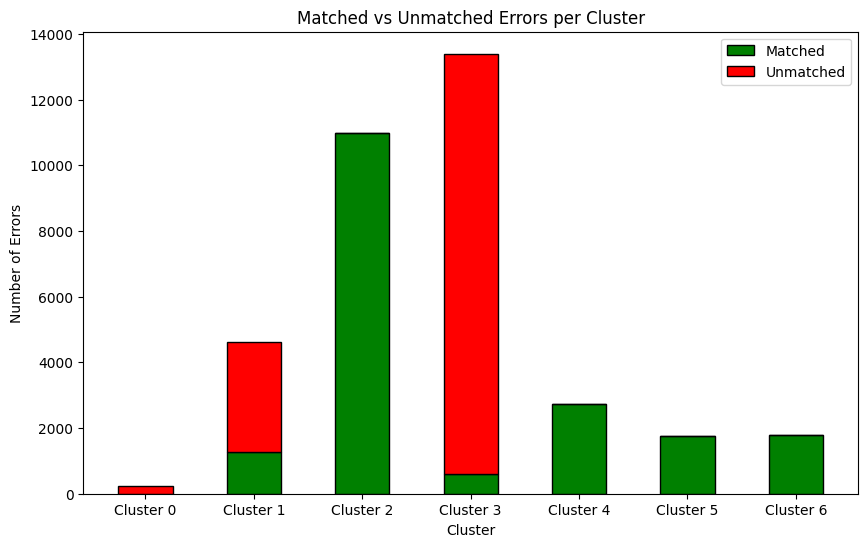

In [78]:
# evaluation on all clusters
n_clusters = df_errors['cluster'].nunique()

# Create a plot that shows with a stacked histogram how many of the total elements of a cluster are matched (green block) and how many are not (red block)
total_counts = [
    len(df_errors[df_errors['cluster'] == cluster]) for cluster in range(n_clusters)
]
print(total_counts)
matched_counts = [
    matched_abs_number.get(cluster) for cluster in range(n_clusters)
]
print(matched_counts)
unmatched_counts = [
    total_counts[cluster] - matched_counts[cluster] for cluster in range(n_clusters)
]

# Plotting the stacked histogram
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.5
bar_positions = np.arange(n_clusters)

ax.bar(bar_positions, matched_counts, color='green', edgecolor='black', width=bar_width, label='Matched')
ax.bar(bar_positions, unmatched_counts, bottom=matched_counts, color='red', edgecolor='black', width=bar_width, label='Unmatched')

ax.set_xlabel('Cluster')
ax.set_ylabel('Number of Errors')
ax.set_title('Matched vs Unmatched Errors per Cluster')
ax.set_xticks(bar_positions)
ax.set_xticklabels([f'Cluster {i}' for i in range(n_clusters)])
ax.legend()

plt.show()